In [40]:
#Importar bibliotecas
import pandas as pd
import seaborn as sns
import psycopg2 as pg2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [41]:
#Conectando com o PostgreSQL
conn = pg2.connect(database='DP6', user='postgres', password='200613')
cur=conn.cursor()
#Query no PostgreSQL
cur.execute('''
    SELECT q0.fullvisitorid, q0.receita,q0.qt_de_transações,
    q0.media_por_transação,q1.qt_de_sessões_conversão,q2.qt_de_sessões
    FROM (SELECT fullvisitorid, 
        SUM(revenue) AS Receita,
        COUNT(fullvisitorid) AS qt_de_transações,
        AVG(revenue) AS media_por_transação
        FROM hits
        GROUP BY (fullvisitorid)) 
        AS q0
    INNER JOIN (SELECT sessions.fullvisitorid, 
        COUNT(DISTINCT sessions.visitnumber) AS qt_de_sessões_conversão
        FROM sessions
        INNER JOIN hits
        ON hits.fullvisitorid = sessions.fullvisitorid
        WHERE hits.visitid = sessions.visitid 
        GROUP BY sessions.fullvisitorid) 
        AS q1
    ON q0.fullvisitorid = q1.fullvisitorid
    LEFT OUTER JOIN (SELECT fullvisitorid,
        COUNT(visitid) AS qt_de_sessões
        FROM sessions
        GROUP BY fullvisitorid) 
        AS q2
    ON q0.fullvisitorid = q2.fullvisitorid
    ''')
#Fechando conexão
data_base=cur.fetchall()
atv1=pd.DataFrame(data_base,columns=['fullvisitorid', 'Receita','Qt_de_transações',
'Media_por_transação','Qt_de_sessões_conversão','Qt_de_sessões'])
cur.close()
conn.commit()

In [42]:
#Conectando com o PostgreSQL
conn = pg2.connect(database='DP6', user='postgres', password='200613')
cur=conn.cursor()
#Query no PostgreSQL
cur.execute('''
    SELECT DISTINCT q1.fullvisitorid, sessions.geonetwork_country,
    sessions.geonetwork_continent
    FROM (SELECT sessions.fullvisitorid, 
        COUNT(DISTINCT sessions.visitnumber) AS qt_de_sessões_conversão
        FROM sessions
        INNER JOIN hits
        ON hits.fullvisitorid = sessions.fullvisitorid
        WHERE hits.visitid = sessions.visitid 
        GROUP BY sessions.fullvisitorid) AS q1
    INNER JOIN sessions
    ON q1.fullvisitorid = sessions.fullvisitorid
    ORDER BY q1.fullvisitorid
    ''')
#Fechando conexão
data_base=cur.fetchall()
atv2=pd.DataFrame(data_base,columns=['fullvisitorid', 'geonetwork_country',
'geonetwork_continent'])
cur.close()
conn.commit()

In [43]:
#Clusterizando clientes por receita e média por transação
amostra=atv1[['Receita','Media_por_transação']]
km = KMeans(n_clusters=3)
label=km.fit_predict(amostra)

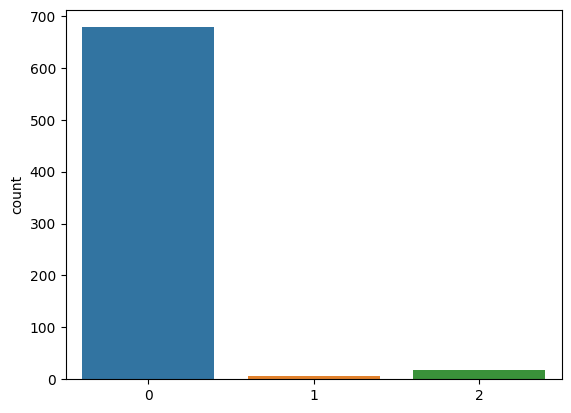

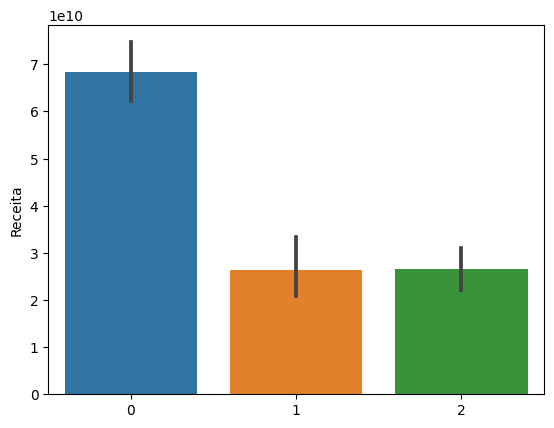

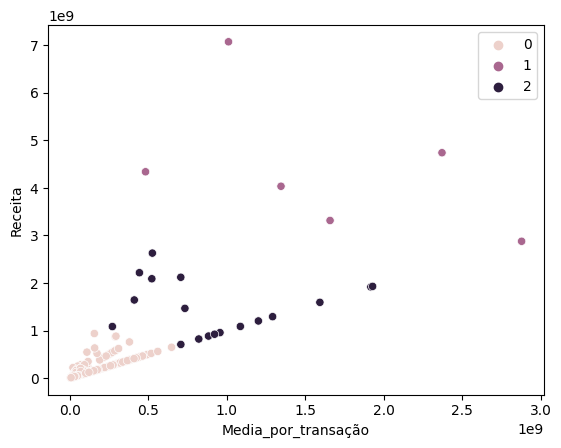

In [44]:
#Plotando resultados
sns.countplot(x=label,data=amostra)
plt.show()
sns.barplot(x=label, y='Receita',estimator=sum, data=amostra)
plt.show()
sns.scatterplot(data=amostra, x='Media_por_transação',y='Receita',hue=label)
plt.show()

In [45]:
#Podemos listar três tipos de clientes:
# 1º Os que compram pouco em poucas transações
# 2º Os que gastam uma quantia média em um número regular de transações
# 3º E os que gastam uma quantia grande porém não tem um perfil exato no número de transações

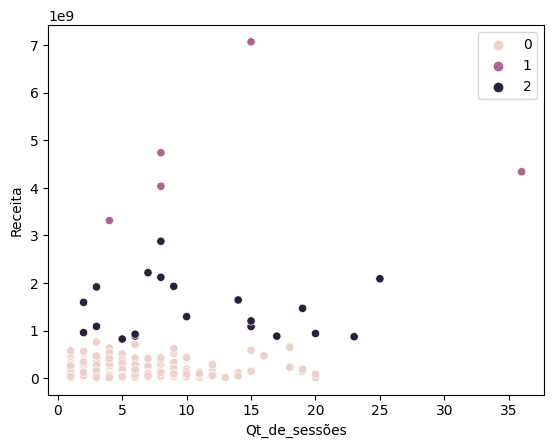

In [46]:
#Clusterizando clientes por receita e quantidade de sessões
amostra2=atv1[['Receita','Qt_de_sessões']]
amostra2=amostra2[amostra2['Qt_de_sessões']<40]
km2 = KMeans(n_clusters=3)
label2=km2.fit_predict(amostra2)
sns.scatterplot(data=amostra2, x='Qt_de_sessões',y='Receita',hue=label2)
plt.show()

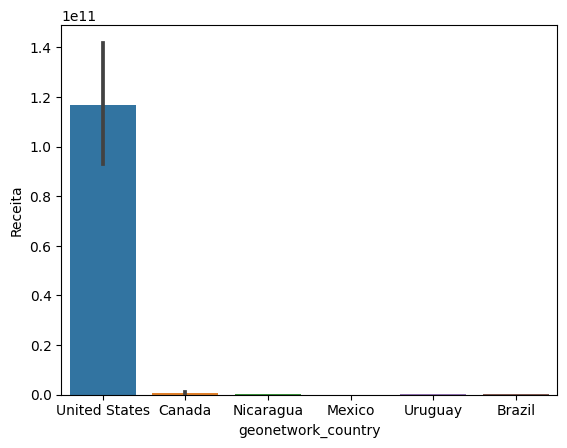

In [47]:
#Entendendo de qual país vem a maior receita
atv3=pd.merge(left=atv1,right=atv2,how='inner',on='fullvisitorid')
atv3=atv3[atv3['geonetwork_continent']=='Americas']
sns.barplot(x='geonetwork_country',y='Receita',estimator=sum,data=atv3)
plt.show()